# ViT Approach to Oops!

https://keras.io/examples/vision/vit_small_ds/


In [ ]:
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [1]:
# ViT Imports
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tensorflow.keras import layers

# Our Imports
import json
import glob
import csv
import cv2
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!rm -rf train
!rm -rf val

In [ ]:
!unzip -qq train_labels.zip -d train_labels
!unzip -qq val_labels.zip -d val_labels

## Mode

In [2]:
mode = 'binary' # 'frame' or 'binary'

## 100x100 Loader

In [ ]:
# 100 x 100
!unzip -qq train_concat_100.zip -d train
!unzip -qq val_concat_100.zip -d val
!mv train/concat_100/*.jpg train
!mv val/concat_100/*.jpg val
!rm -rf train/concat_100
!rm -rf val/concat_100

In [ ]:
data_image_size = (100, 100)
data_patch_size = 20
data_input_shape = (100, 100, 1)

## 1200x1200 Loader

In [ ]:
# 1200 x 1200
!unzip -qq train_concat_1200.zip -d train
!unzip -qq val_concat_1200.zip -d val
!mv train/concat_1200/*.jpg train
!mv val/concat_1200/*.jpg val
!rm -rf train/concat_1200
!rm -rf val/concat_1200

unzip:  cannot find or open train_concat_1200.zip, train_concat_1200.zip.zip or train_concat_1200.zip.ZIP.
unzip:  cannot find or open val_concat_1200.zip, val_concat_1200.zip.zip or val_concat_1200.zip.ZIP.
mv: cannot stat 'train/concat_1200/*.jpg': No such file or directory
mv: cannot stat 'val/concat_1200/*.jpg': No such file or directory


In [3]:
data_image_size = (1200, 1200)
data_patch_size = 240
data_input_shape = (1200, 1200, 1)

## Load Data

In [4]:
info_json_path = "small_transition_times.json"
info_json = json.load(open(info_json_path))

In [5]:
train_oops_labels = []
train_time_labels = []
val_oops_labels = []
val_time_labels = []

for name in sorted(glob.glob("train/*")):
  name = name[6:-5]
  if info_json[name]['label'] == 'oops':
    train_oops_labels.append(1)
    # train_time_labels.append(np.mean(info_json[name]['t']))
    with open("train_labels/" + name + "_labels.csv", "r") as f:
      r = csv.reader(f, delimiter=',', quotechar='|')
      for row in r:
        transition_time = row.index('1')
    if transition_time < 6:
      transition_time = 6
    train_time_labels.append(transition_time - 6)
  else:
    train_oops_labels.append(0)
    train_time_labels.append(15)

for name in sorted(glob.glob("val/*")):
  name = name[4:-5]
  if info_json[name]['label'] == 'oops':
    val_oops_labels.append(1)
    # val_time_labels.append(np.mean(info_json[name]['t']))
    with open("val_labels/" + name + "_labels.csv", "r") as f:
      r = csv.reader(f, delimiter=',', quotechar='|')
      for row in r:
        transition_time = row.index('1')
    if transition_time < 6:
      transition_time = 6
    val_time_labels.append(transition_time - 6)
  else:
    val_oops_labels.append(0)
    val_time_labels.append(15)


In [6]:
print(train_oops_labels[0:10])
print(train_time_labels[0:10])
print(val_oops_labels[0:10])
print(val_time_labels[0:10])


[0, 1, 1, 1, 0, 1, 0, 1, 1, 1]
[15, 11, 5, 14, 15, 7, 15, 3, 9, 9]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[4, 4, 7, 15, 9, 2, 7, 15, 11, 11]


In [7]:
if mode == 'binary':
  train_labels = train_oops_labels
  val_labels = val_oops_labels
  n_classes = 2
else:
  train_labels = train_time_labels
  val_labels = val_time_labels
  n_classes = 16

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    directory="train",
    color_mode='grayscale',
    image_size=data_image_size,
    batch_size=None,
    labels=train_labels,
    # label_mode='categorical',
    shuffle=True
)
val_ds = keras.utils.image_dataset_from_directory(
    directory="val",
    color_mode='grayscale',
    image_size=data_image_size,
    batch_size=None,
    labels=val_labels,
    # label_mode='categorical',
    shuffle=True
)


Found 1015 files belonging to 2 classes.
Found 240 files belonging to 2 classes.


In [9]:
x_train = np.array([x for x, _ in train_ds.as_numpy_iterator()])
y_train = np.array([y for _, y in train_ds.as_numpy_iterator()])
x_val = np.array([x for x, _ in val_ds.as_numpy_iterator()])
y_val = np.array([y for _, y in val_ds.as_numpy_iterator()])

In [10]:
NUM_CLASSES = n_classes
INPUT_SHAPE = data_input_shape # Altered from

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_val.shape} - y_test shape: {y_val.shape}")

x_train shape: (1015, 1200, 1200, 1) - y_train shape: (1015,)
x_test shape: (240, 1200, 1200, 1) - y_test shape: (240,)


In [11]:
print(np.unique(y_train))
print(np.unique(y_val))

[0 1]
[0 1]


## ViT Architecture

The ViT Architecture derives from the Keras code example given [in this repository](https://keras.io/examples/vision/vit_small_ds/) authored by Aritra Roy Gosthipaty.

Modifications not contained in the original source code are ours.

### Hyperparameters

In [13]:
# # DATA
# BUFFER_SIZE = 64 #64
# BATCH_SIZE = 32

# # AUGMENTATION
# IMAGE_SIZE = data_image_size[0]
# PATCH_SIZE = data_patch_size
# NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# # OPTIMIZER
# LEARNING_RATE = 0.001 # .001 -> .01
# WEIGHT_DECAY = 0.0001

# # TRAINING
# EPOCHS = 50

# # ARCHITECTURE
# LAYER_NORM_EPS = 1e-6
# TRANSFORMER_LAYERS = 8
# PROJECTION_DIM = 64
# NUM_HEADS = 4
# TRANSFORMER_UNITS = [
#     PROJECTION_DIM * 2,
#     PROJECTION_DIM,
# ]
# MLP_HEAD_UNITS = [2048, 1024]

### Architecture

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        # layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [15]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

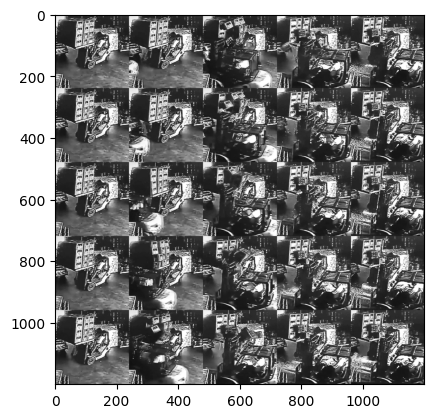

In [16]:
plt.imshow(x_train[2], cmap='gray')
plt.show()

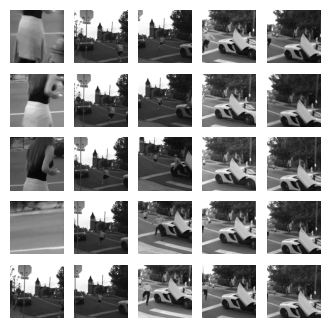

In [17]:
# Get a random image from the training dataset
# and resize the image
# image = x_train[np.random.choice(range(x_train.shape[0]))]
image = x_train[0]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 1))
        plt.imshow(image, cmap='gray')
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
# (token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
# (token, patch) = (token[0], patch[0])
# n = patch.shape[0]
# shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
# for index, name in enumerate(shifted_images):
#     print(name)
#     count = 1
#     plt.figure(figsize=(4, 4))
#     for row in range(n):
#         for col in range(n):
#             plt.subplot(n, n, count)
#             count = count + 1
#             image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
#             plt.imshow(image[..., 3 * index : 3 * index + 3])
#             plt.axis("off")
#     plt.show()

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [19]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [20]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [21]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=True)(augmented) # We don't want ShiftedPatchTokenization
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output, attention_scores = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask, return_attention_scores=True)
        else:
            attention_output, attention_scores = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, return_attention_scores=True)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [22]:
# Project code
def accuracy_within_proximity(y_true, y_pred, proximity=1):
  sum = 0
  for idx in range(len(y_true)):
    y_p = np.argmax(y_pred[idx])
    y_t = y_true[idx]
    # print(y_p)
    # print(y_t)
    if y_p == 15 != y_t == 15:
      sum += 0
    else:
      if abs(y_t - y_p) <= proximity:
        sum += 1
      else:
        sum += 0
  accuracy = sum / len(y_true)
  return accuracy

### Experiment

In [23]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    ### MODIFICATION
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #   initial_learning_rate=1e-2,
    #   decay_steps=10000,
    #   decay_rate=0.9)

    ###

    optimizer = tfa.optimizers.AdamW(
        # learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        # validation_split=0.1,
        validation_data=(x_val, y_val),
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)

    accuracies = {}

    accuracies['Test'] = accuracy
    accuracies['Test top 5'] = top_5_accuracy

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    val_pred = model.predict(x_val)
    for i in range(3):
        accuracies['Proximity_' + str(i+1)] = accuracy_within_proximity(y_val, val_pred, i + 1)

    return history, accuracies, val_pred


# Run experiments with the vanilla ViT
# vit = create_vit_classifier(vanilla=True)
# history, accuracies, val_pred  = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
# vit_sl = create_vit_classifier(vanilla=False)
# history = run_experiment(vit_sl)

## Visualizations

### Stats

In [24]:
# Plotting stats

def plot_accuracies(train_acc, val_acc):
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.title('Accuracies')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

def plot_losses(train_loss, val_loss):
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

def show_plots(history):
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plot_accuracies(history.history['accuracy'], history.history['val_accuracy'])
  plt.subplot(1, 2, 2)
  plot_losses(history.history['loss'], history.history['val_loss'])
  plt.show()

### Attention

In [25]:
# This code block is adapted from the file in the following repository and is
# subject to its licenses
# https://github.com/faustomorales/vit-keras/blob/master/vit_keras/visualize.py
def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).

    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    img_height, img_width = model.input_shape[1], model.input_shape[2]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2])) # no class token
    # print(grid_size)

    # Prepare the input
    # X = vit.preprocess_inputs(cv2.resize(image, (img_height, img_width)))[np.newaxis, :]  # type: ignore
    X = image[np.newaxis, :]
    # print(X.shape)
    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.MultiHeadAttention)
    ]

    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    # print(weights.shape)
    # weights = weights.squeeze()

    num_layers = weights.shape[0]
    num_heads = weights.shape[2]

    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size**2, grid_size**2) # no class token
    )

    # Should be num_layers, _, num_heads, _

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])
    # print(v.shape)
    # Attention from the output token to the input space.
    # mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = v[0, 0:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    # return (mask * image).astype("uint8")
    return mask

In [26]:
def mask_visualize(image, mask=None):
  # imgplot = plt.figure(figsize=(10, 40))
  fig = plt.figure(frameon=False)

  c_white = colors.colorConverter.to_rgba('red',alpha = 0)
  c_black = colors.colorConverter.to_rgba('blue',alpha = .75)
  cmap_rb = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black],512)

  imgplot = plt.imshow(image, cmap="gray")
  if mask is not None:
    annplot = plt.imshow(mask, alpha=1, cmap=cmap_rb)
  plt.show()


In [27]:
def show_attention_maps(vit, y_pred, mode='frame', n=2):
  if mode == 'frame':
    max_val = 15
  else:
    max_val = 1
  y_pred = np.argmax(y_pred, axis=1)
  print ("+++ ATTN MAPS | CORRECT +++")
  correct = np.squeeze(np.argwhere((y_pred == y_val) & (y_val < max_val)))
  correct_sample = np.random.choice(correct, size=n-1)
  for i in correct_sample:
    print("IDX:", i)
    image = x_val[i]
    label = y_val[i]
    if label == 15:
      label_frame = -1
    else:
      label_frame = label + 6
    print("Label Frame:", label_frame)
    pred = y_pred[i]
    if pred == 15:
      pred_frame = -1
    else:
      pred_frame = pred + 6
    print("Predicted:", pred_frame)
    mask = attention_map(vit, image)
    mask_visualize(image, mask)

  correct = np.squeeze(np.argwhere((y_pred == y_val) & (y_val == max_val)))
  correct_sample = np.random.choice(correct, size=1)
  for i in correct_sample:
    print("IDX:", i)
    image = x_val[i]
    label = y_val[i]
    if label == 15:
      label_frame = -1
    else:
      label_frame = label + 6
    print("Label Frame:", label_frame)
    pred = y_pred[i]
    if pred == 15:
      pred_frame = -1
    else:
      pred_frame = pred + 6
    print("Predicted:", pred_frame)
    mask = attention_map(vit, image)
    mask_visualize(image, mask)

  print("+++ ATTN MAPS | INCORRECT +++")
  incorrect = np.squeeze(np.argwhere((y_pred != y_val) & (y_val < max_val)))
  incorrect_sample = np.random.choice(incorrect, size=n-1)
  for i in incorrect_sample:
    print("IDX:", i)
    image = x_val[i]
    label = y_val[i]
    if label == 15:
      label_frame = -1
    else:
      label_frame = label + 6
    print("Label Frame:", label_frame)
    pred = y_pred[i]
    if pred == 15:
      pred_frame = -1
    else:
      pred_frame = pred + 6
    print("Predicted:", pred_frame)
    mask = attention_map(vit, image)
    mask_visualize(image, mask)

  incorrect = np.squeeze(np.argwhere((y_pred != y_val) & (y_val == max_val)))
  incorrect_sample = np.random.choice(incorrect, size=1)
  for i in incorrect_sample:
    print("IDX:", i)
    image = x_val[i]
    label = y_val[i]
    if label == 15:
      label_frame = -1
    else:
      label_frame = label + 6
    print("Label Frame:", label_frame)
    pred = y_pred[i]
    if pred == 15:
      pred_frame = -1
    else:
      pred_frame = pred + 6
    print("Predicted:", pred_frame)
    mask = attention_map(vit, image)
    mask_visualize(image, mask)

In [28]:
def show_confusion_matrix(y_val, y_pred, mode):
  if mode == 'frame':
    labels = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1]
  else:
    labels = ['No Oops', 'Oops']
  conf_mat = confusion_matrix(y_val, y_pred)
  disp = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
  disp.plot()
  plt.show()

## Experiments

In [29]:
def experimental_trial():
  SEED = 42
  keras.utils.set_random_seed(SEED)
  vit = create_vit_classifier(vanilla=True)
  history, accuracies, val_pred = run_experiment(vit)
  return vit, history, accuracies, val_pred

In [30]:
def experiment_results(vit, history, accuracies, val_pred, mode):
  y_val_pred = np.argmax(val_pred, axis=1)
  yp = y_val_pred
  print("================ ACCURACIES ================")
  print('Val Acc.', round(accuracies['Test'] * 100, 2))
  print('Val Top 5 Acc.', round(accuracies['Test top 5'] * 100, 2))
  print('Prox. 1 Acc.', round(accuracies['Proximity_1'] * 100, 2))
  print('Prox. 2 Acc.', round(accuracies['Proximity_2'] * 100, 2))
  print('Prox. 3 Acc.', round(accuracies['Proximity_3'] * 100, 2))
  print('F1 Score Micro', f1_score(y_val, yp, average='micro'))
  print('F1 Score Macro', f1_score(y_val, yp, average='macro'))
  print('F1 Score Weighted', f1_score(y_val, yp, average='weighted'))
  show_confusion_matrix(y_val, yp, mode)
  print("================= TRAINING =================")
  show_plots(history)
  print("================= ATTENTION ================")
  show_attention_maps(vit, val_pred, mode)

In [31]:
def full_experiment():
  vit, history, accuracies, val_pred = experimental_trial()
  experiment_results(vit, history, accuracies, val_pred, mode)

## Results - 1200x1200

### Study 0: Projection Dim Size 64

In [37]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64 # <---
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 20s 243ms/step - loss: 3.7092 - accuracy: 0.1754 - top-5-accuracy: 0.4640 - val_loss: 2.6856 - val_accuracy: 0.1875 - val_top-5-accuracy: 0.5375
Epoch 2/50
32/32 [==============================] - 4s 115ms/step - loss: 3.2920 - accuracy: 0.1990 - top-5-accuracy: 0.5084 - val_loss: 2.7270 - val_accuracy: 0.2125 - val_top-5-accuracy: 0.4667
Epoch 3/50
32/32 [==============================] - 4s 112ms/step - loss: 3.1005 - accuracy: 0.2315 - top-5-accuracy: 0.5271 - val_loss: 2.7839 - val_accuracy: 0.1958 - val_top-5-accuracy: 0.4250
Epoch 4/50
32/32 [==============================] - 4s 110ms/step - loss: 2.8519 - accuracy: 0.2296 - top-5-accuracy: 0.5369 - val_loss: 2.5682 - val_accuracy: 0.2958 - val_top-5-accuracy: 0.5333
Epoch 5/50
32/32 [==============================] - 4s 117ms/step - loss: 2.6672 - accuracy: 0.2552 - top-5-accuracy: 0.5882 - val_loss: 2.5490 - val_accuracy: 0.3208 - val_top-5-accuracy: 0.5417
Epoch 6/50
32/32 [=

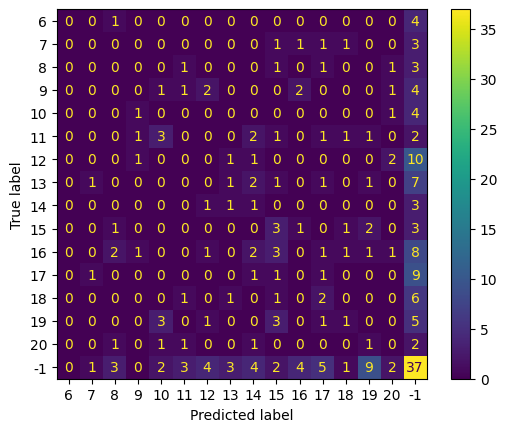

================= TRAINING =================


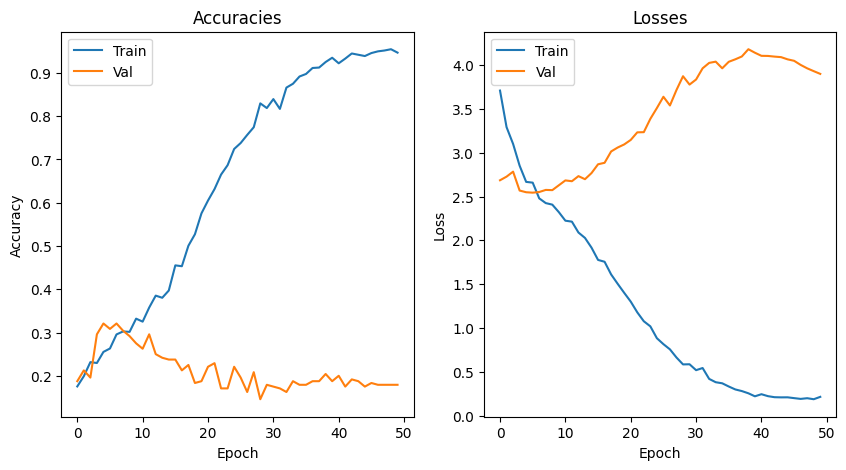

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 123
Label Frame: 17
Predicted: 17
1/1 [==============================] - 1s 1s/step


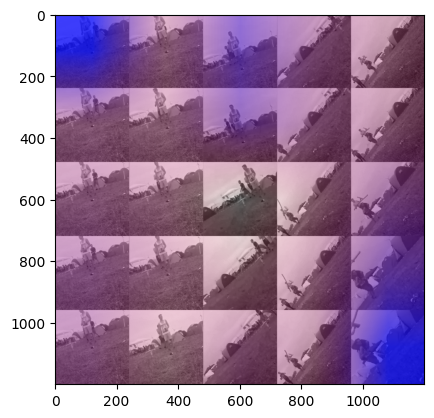

IDX: 180
Label Frame: -1
Predicted: -1
1/1 [==============================] - 1s 1s/step


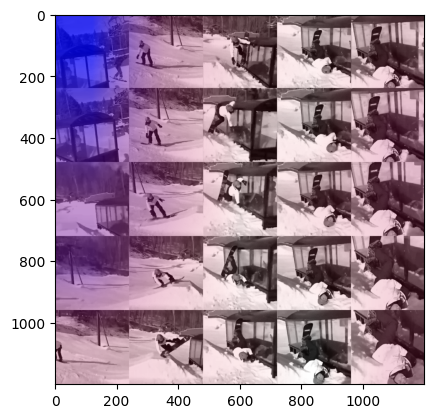

+++ ATTN MAPS | INCORRECT +++
IDX: 18
Label Frame: 11
Predicted: 10
1/1 [==============================] - 1s 1s/step


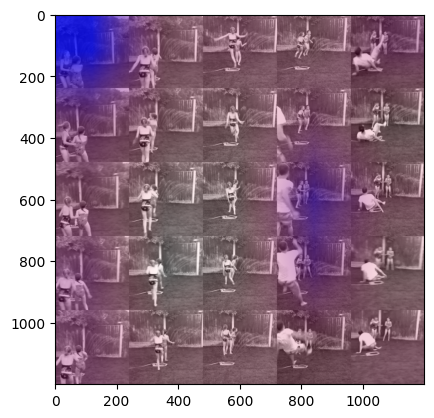

IDX: 237
Label Frame: -1
Predicted: 16


1/1 [==============================] - 1s 1000ms/step


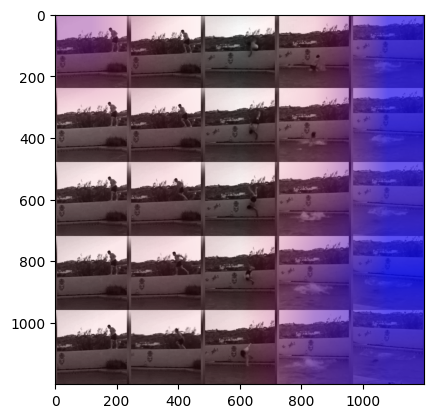

In [38]:
full_experiment()

### Study 1: Projection Dim Size 128

In [12]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 128 # <---
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 20s 248ms/step - loss: 4.2893 - accuracy: 0.1567 - top-5-accuracy: 0.4187 - val_loss: 2.7400 - val_accuracy: 0.1750 - val_top-5-accuracy: 0.4667
Epoch 2/50
32/32 [==============================] - 4s 112ms/step - loss: 3.6649 - accuracy: 0.1655 - top-5-accuracy: 0.4897 - val_loss: 2.8883 - val_accuracy: 0.1667 - val_top-5-accuracy: 0.4250
Epoch 3/50
32/32 [==============================] - 4s 111ms/step - loss: 3.3243 - accuracy: 0.2010 - top-5-accuracy: 0.5300 - val_loss: 2.7040 - val_accuracy: 0.3250 - val_top-5-accuracy: 0.4958
Epoch 4/50
32/32 [==============================] - 4s 115ms/step - loss: 3.0243 - accuracy: 0.2266 - top-5-accuracy: 0.5704 - val_loss: 2.6644 - val_accuracy: 0.2833 - val_top-5-accuracy: 0.5125
Epoch 5/50
32/32 [==============================] - 4s 116ms/step - loss: 2.8613 - accuracy: 0.2345 - top-5-accuracy: 0.5547 - val_loss: 2.6471 - val_accuracy: 0.2708 - val_top-5-accuracy: 0.5083
Epoch 6/50
32/32 [=

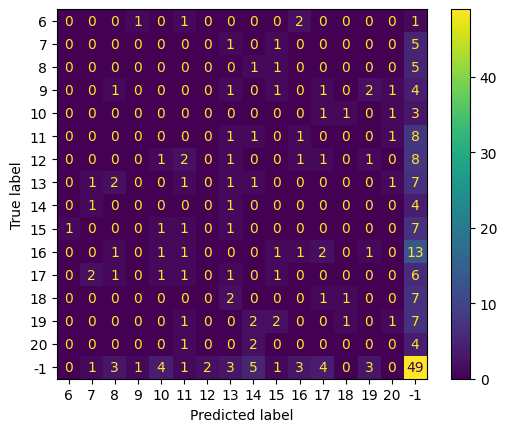

================= TRAINING =================


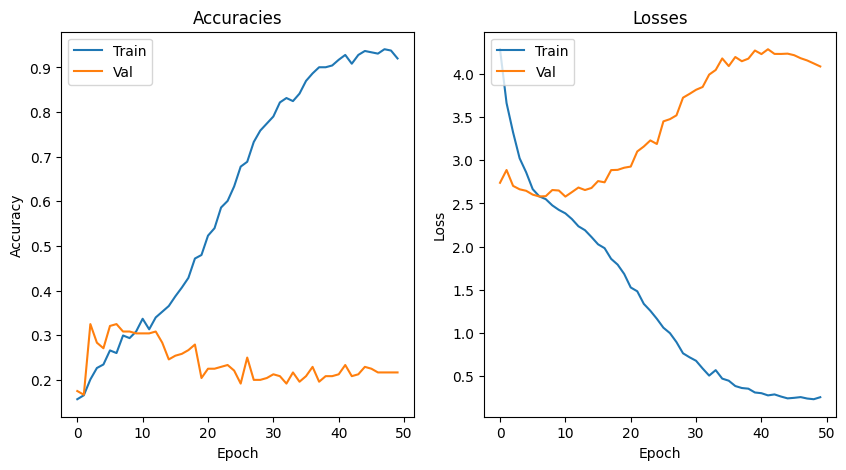

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 200
Label Frame: 16
Predicted: 16
1/1 [==============================] - 1s 1s/step


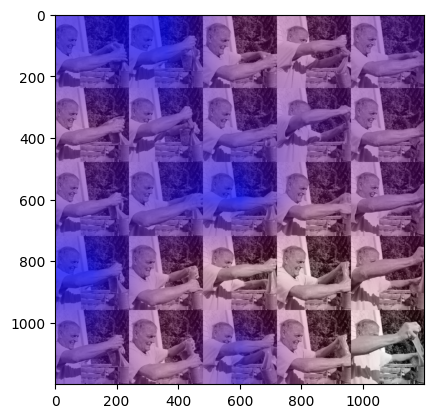

IDX: 155
Label Frame: -1
Predicted: -1
1/1 [==============================] - 1s 997ms/step


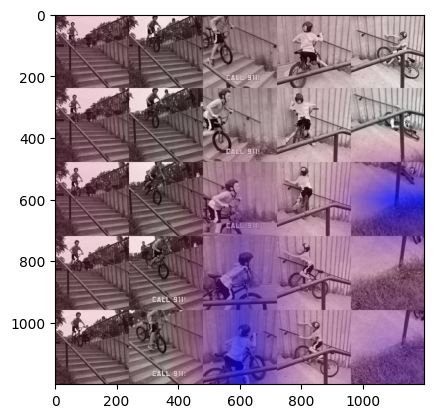

+++ ATTN MAPS | INCORRECT +++
IDX: 21
Label Frame: 14
Predicted: 13
1/1 [==============================] - 1s 1s/step


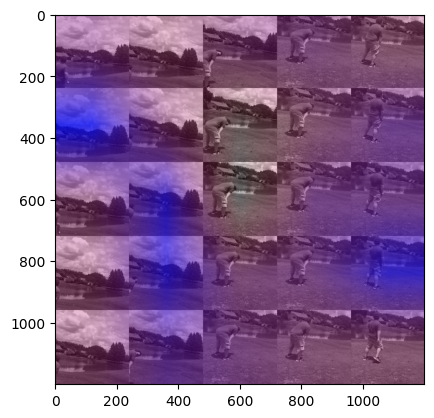

IDX: 62
Label Frame: -1
Predicted: 17


1/1 [==============================] - 1s 1s/step


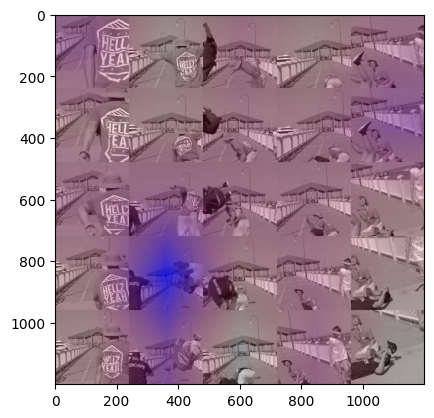

In [41]:
full_experiment()

### Study 2: Learning Rate - Fixed

In [14]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001 # <--- Now fixed
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 128
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 20s 249ms/step - loss: 6.1924 - accuracy: 0.1557 - top-5-accuracy: 0.4591 - val_loss: 4.2542 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.5042
Epoch 2/50
32/32 [==============================] - 4s 116ms/step - loss: 3.8231 - accuracy: 0.2099 - top-5-accuracy: 0.5005 - val_loss: 2.5924 - val_accuracy: 0.2875 - val_top-5-accuracy: 0.5250
Epoch 3/50
32/32 [==============================] - 4s 114ms/step - loss: 2.7768 - accuracy: 0.2453 - top-5-accuracy: 0.5517 - val_loss: 2.6003 - val_accuracy: 0.2875 - val_top-5-accuracy: 0.5208
Epoch 4/50
32/32 [==============================] - 4s 114ms/step - loss: 2.6411 - accuracy: 0.2749 - top-5-accuracy: 0.5655 - val_loss: 2.5900 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.5292
Epoch 5/50
32/32 [==============================] - 4s 116ms/step - loss: 2.5561 - accuracy: 0.2729 - top-5-accuracy: 0.5961 - val_loss: 2.6350 - val_accuracy: 0.2958 - val_top-5-accuracy: 0.5083
Epoch 6/50
32/32 [=

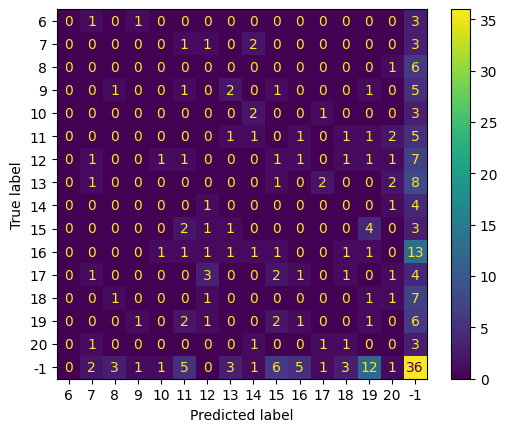

================= TRAINING =================


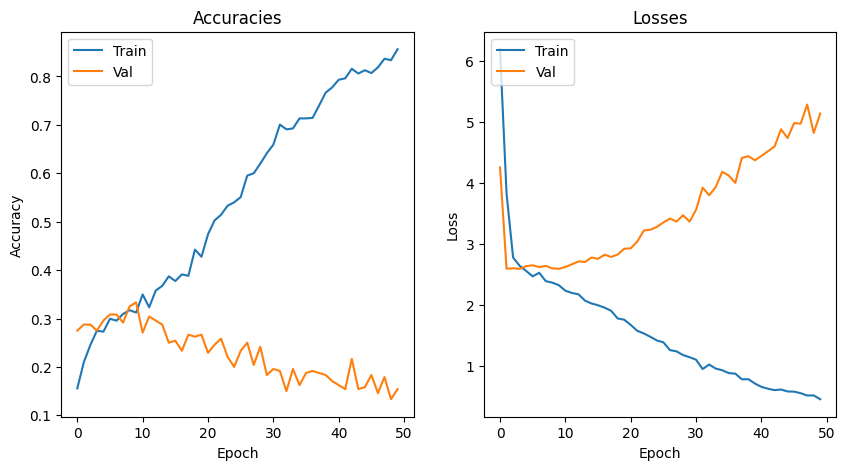

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 6
Label Frame: 11
Predicted: -1
1/1 [==============================] - 1s 1s/step


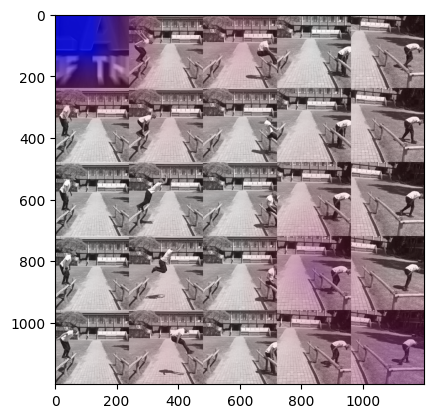

IDX: 192
Label Frame: -1
Predicted: -1
1/1 [==============================] - 1s 1s/step


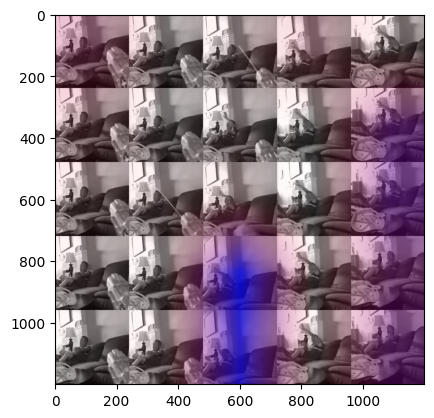

+++ ATTN MAPS | INCORRECT +++
IDX: 16
Label Frame: 12
Predicted: 20
1/1 [==============================] - 1s 1s/step


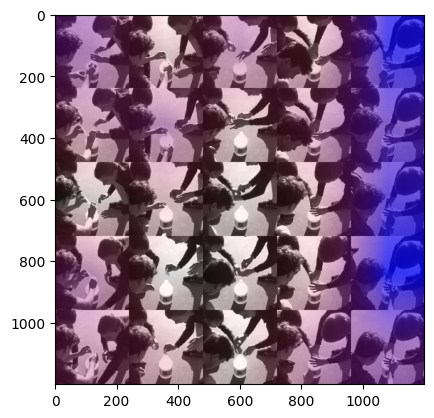

IDX: 232
Label Frame: -1
Predicted: 19


1/1 [==============================] - 1s 1s/step


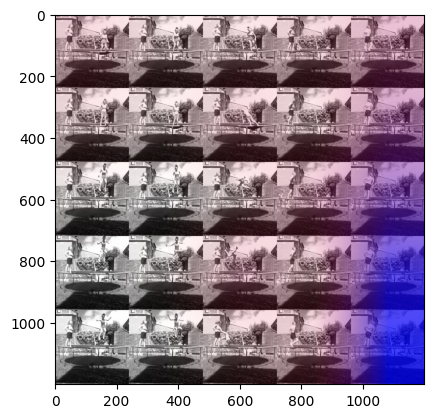

In [33]:
full_experiment()

### Study 3: Learning Scheduler - Smaller

In [16]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.0001 # <---
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 128
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 20s 243ms/step - loss: 4.8282 - accuracy: 0.0571 - top-5-accuracy: 0.3123 - val_loss: 2.6009 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.5208
Epoch 2/50
32/32 [==============================] - 3s 110ms/step - loss: 3.7998 - accuracy: 0.1665 - top-5-accuracy: 0.4897 - val_loss: 2.5406 - val_accuracy: 0.3167 - val_top-5-accuracy: 0.5333
Epoch 3/50
32/32 [==============================] - 4s 113ms/step - loss: 3.5057 - accuracy: 0.2059 - top-5-accuracy: 0.5300 - val_loss: 2.5442 - val_accuracy: 0.2917 - val_top-5-accuracy: 0.5125
Epoch 4/50
32/32 [==============================] - 4s 117ms/step - loss: 3.3507 - accuracy: 0.1882 - top-5-accuracy: 0.5448 - val_loss: 2.5773 - val_accuracy: 0.3208 - val_top-5-accuracy: 0.5292
Epoch 5/50
32/32 [==============================] - 4s 111ms/step - loss: 3.2003 - accuracy: 0.2325 - top-5-accuracy: 0.5458 - val_loss: 2.5734 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.5083
Epoch 6/50
32/32 [=

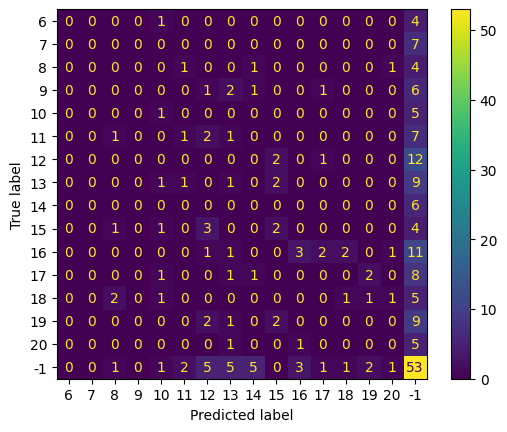

================= TRAINING =================


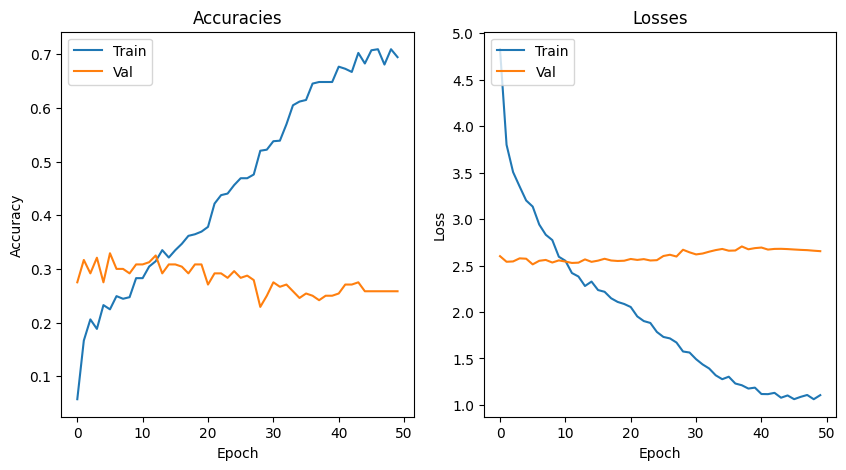

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 153
Label Frame: 15
Predicted: 15
1/1 [==============================] - 1s 982ms/step


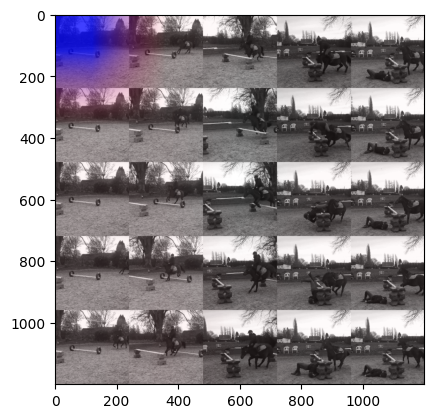

IDX: 230
Label Frame: -1
Predicted: -1
1/1 [==============================] - 1s 959ms/step


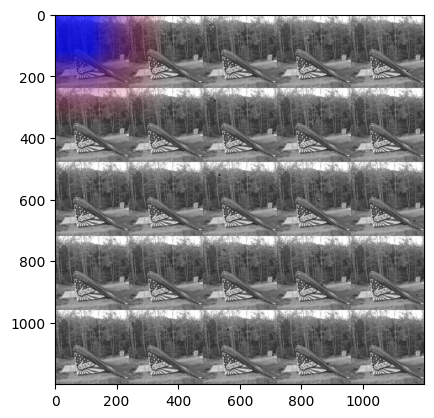

+++ ATTN MAPS | INCORRECT +++
IDX: 152
Label Frame: 16
Predicted: 17
1/1 [==============================] - 1s 964ms/step


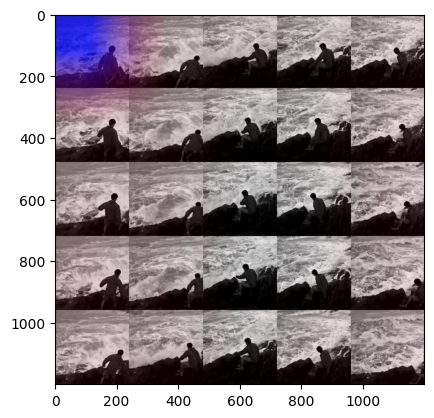

IDX: 111
Label Frame: -1
Predicted: 16


1/1 [==============================] - 1s 982ms/step


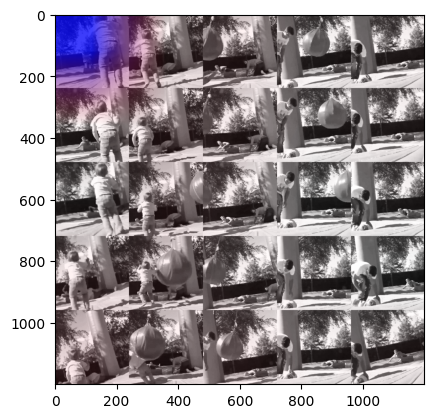

In [36]:
full_experiment()

### Study 4: Attention Not Vanilla

In [12]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 128
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 20s 244ms/step - loss: 4.7856 - accuracy: 0.0709 - top-5-accuracy: 0.3054 - val_loss: 2.5950 - val_accuracy: 0.2875 - val_top-5-accuracy: 0.5083
Epoch 2/50
32/32 [==============================] - 4s 115ms/step - loss: 3.7996 - accuracy: 0.1734 - top-5-accuracy: 0.4966 - val_loss: 2.5941 - val_accuracy: 0.3250 - val_top-5-accuracy: 0.5583
Epoch 3/50
32/32 [==============================] - 4s 116ms/step - loss: 3.5988 - accuracy: 0.1911 - top-5-accuracy: 0.5103 - val_loss: 2.5843 - val_accuracy: 0.3000 - val_top-5-accuracy: 0.5292
Epoch 4/50
32/32 [==============================] - 4s 115ms/step - loss: 3.4775 - accuracy: 0.1931 - top-5-accuracy: 0.5094 - val_loss: 2.5777 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.5583
Epoch 5/50
32/32 [==============================] - 4s 114ms/step - loss: 3.2649 - accuracy: 0.2049 - top-5-accuracy: 0.5271 - val_loss: 2.5817 - val_accuracy: 0.3083 - val_top-5-accuracy: 0.5208
Epoch 6/50
32/32 [=

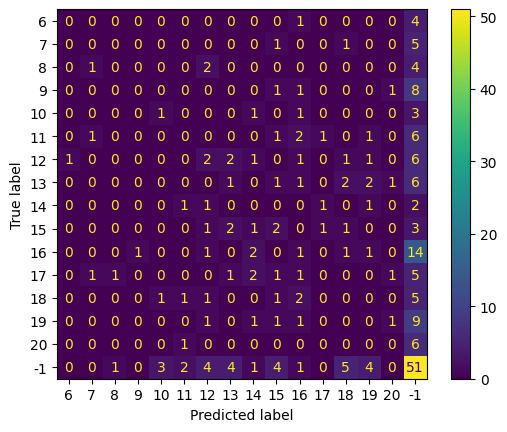

================= TRAINING =================


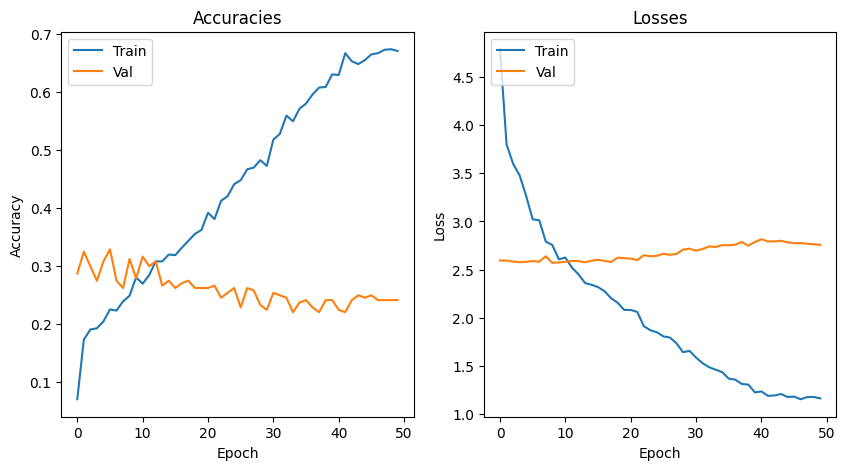

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 210
Label Frame: 16
Predicted: 16
1/1 [==============================] - 1s 1s/step


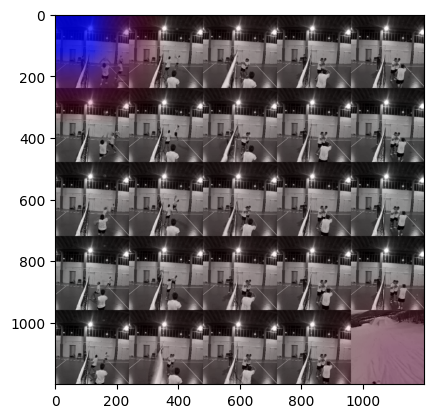

IDX: 119
Label Frame: -1
Predicted: -1
1/1 [==============================] - 1s 1s/step


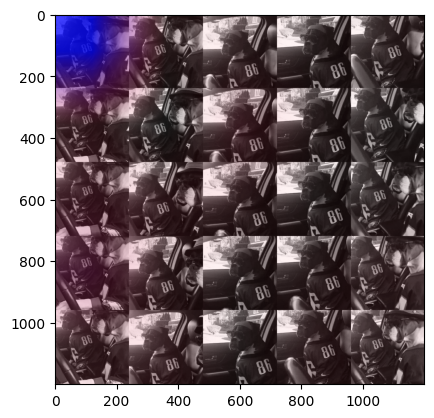

+++ ATTN MAPS | INCORRECT +++
IDX: 21
Label Frame: 13
Predicted: 20
1/1 [==============================] - 1s 1s/step


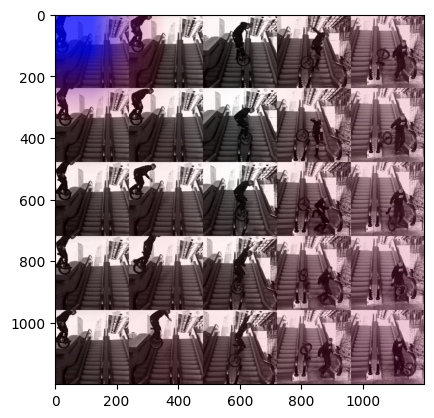

IDX: 72
Label Frame: -1
Predicted: 15


1/1 [==============================] - 1s 1s/step


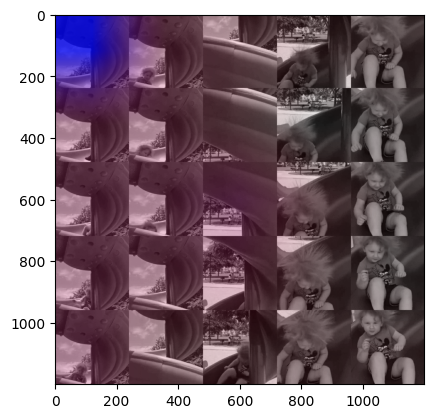

In [32]:
full_experiment()

### Study 5: Binary

In [12]:
# DATA
BUFFER_SIZE = 64 #64
BATCH_SIZE = 32

# AUGMENTATION
IMAGE_SIZE = data_image_size[0]
PATCH_SIZE = data_patch_size
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 128
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Epoch 1/50
32/32 [==============================] - 21s 253ms/step - loss: 1.2808 - accuracy: 0.5409 - top-5-accuracy: 1.0000 - val_loss: 0.7164 - val_accuracy: 0.6333 - val_top-5-accuracy: 1.0000
Epoch 2/50
32/32 [==============================] - 4s 117ms/step - loss: 1.2733 - accuracy: 0.5537 - top-5-accuracy: 1.0000 - val_loss: 0.7753 - val_accuracy: 0.6292 - val_top-5-accuracy: 1.0000
Epoch 3/50
32/32 [==============================] - 4s 116ms/step - loss: 1.2200 - accuracy: 0.5567 - top-5-accuracy: 1.0000 - val_loss: 0.7363 - val_accuracy: 0.6250 - val_top-5-accuracy: 1.0000
Epoch 4/50
32/32 [==============================] - 4s 119ms/step - loss: 1.1668 - accuracy: 0.5783 - top-5-accuracy: 1.0000 - val_loss: 0.7796 - val_accuracy: 0.5208 - val_top-5-accuracy: 1.0000
Epoch 5/50
32/32 [==============================] - 4s 119ms/step - loss: 1.0012 - accuracy: 0.6138 - top-5-accuracy: 1.0000 - val_loss: 0.8968 - val_accuracy: 0.4875 - val_top-5-accuracy: 1.0000
Epoch 6/50
32/32 [=

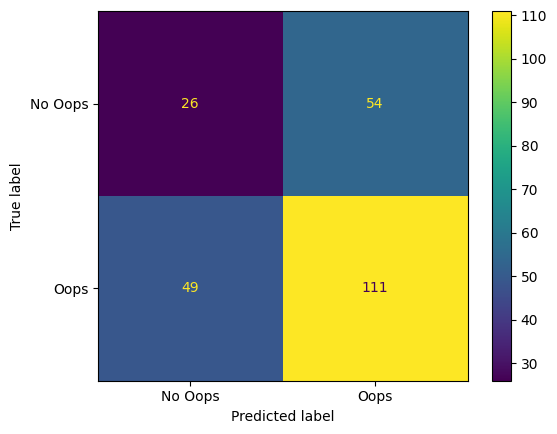

================= TRAINING =================


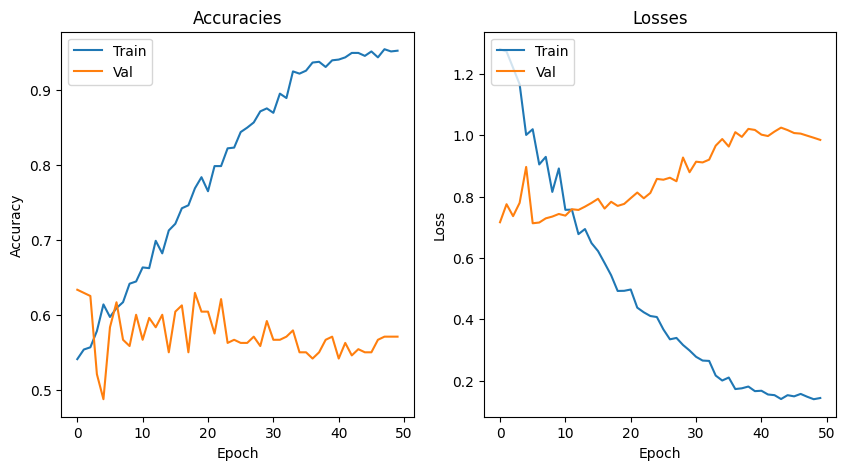

================= ATTENTION ================
+++ ATTN MAPS | CORRECT +++
IDX: 54
Label Frame: 6
Predicted: 6
1/1 [==============================] - 1s 1s/step


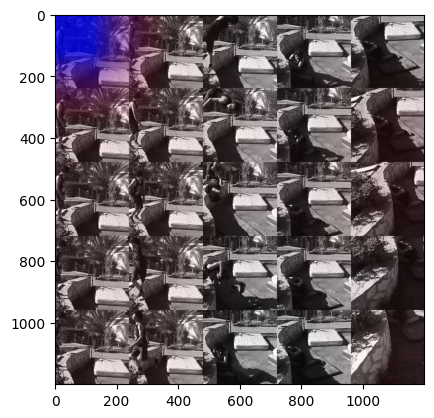

IDX: 99
Label Frame: 7
Predicted: 7
1/1 [==============================] - 1s 1s/step


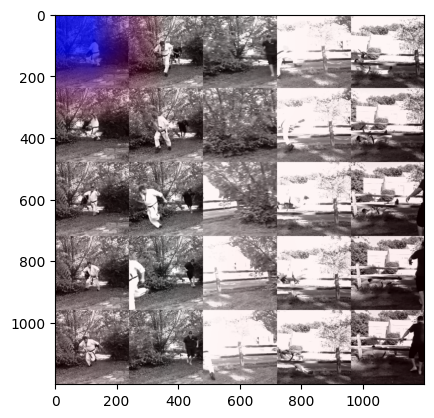

+++ ATTN MAPS | INCORRECT +++
IDX: 133
Label Frame: 6
Predicted: 7
1/1 [==============================] - 1s 1s/step


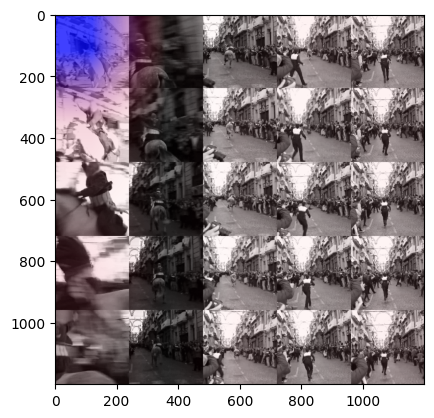

IDX: 67
Label Frame: 7
Predicted: 6


1/1 [==============================] - 1s 1s/step


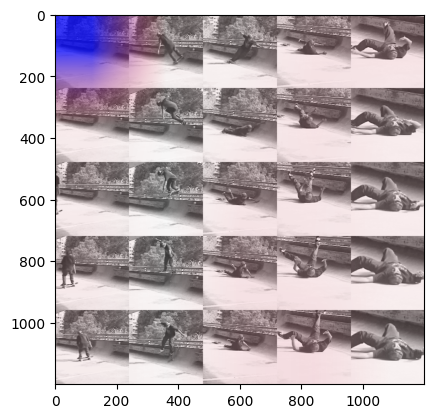

In [32]:
full_experiment()